In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import Fluka_dump_tools as fdt


In [27]:
N_files = 50
Energy = 4550
Rseed = 0

fluka_dir = '/Users/mghrear/Lab/HPS/fluka/'+str(Energy)+'MeV_userdump_s'+str(Rseed)+'/'

In [28]:
# Convert fluka dump files into pandas dataframes
fdt.FlukaDump_toPandas(fluka_dir, N_files, Energy)

#loop through saved pkl files and append them to a single DataFrame
df = pd.DataFrame()
for i in np.arange(1,N_files+1,1):
    i = str(i).zfill(3)
    file_name = fluka_dir+"phiKK_"+str(Energy)+ i + ".pkl"
    temp_df = pd.read_pickle(file_name)
    df = pd.concat([df, temp_df], ignore_index=True)
df.head()

,ProjID,ProjkE,ProjdirX,ProjdirY,ProjdirZ,Gen_No,IntID,NoSecondary,IDs,Ps,Xs,Ys,Zs
0,7,4.240412,0.000148,0.000423,1.0,2,101,18,"[1, 8, 16, 23, 8, 23, 15, 8, 8, 8, 8, 7, 7, 7,...","[0.3908183128574961, 0.5829781480118803, 1.118...","[-0.47165277413042467, 0.8179916855922268, 0.3...","[-0.854948210703991, -0.5285583124856388, -0.0...","[0.21588704840522258, 0.2269707307216539, 0.91..."
1,7,4.071699,0.000013,0.000065,1.0,3,101,25,"[1, 1, 1, 1, 14, 15, 16, 1, 8, 8, 8, 8, 8, 8, ...","[0.24691755171331217, 0.18069759387837567, 0.6...","[0.4814910974118118, 0.38495009761644056, -0.9...","[-0.8757855290728752, -0.7186332699888872, -0....","[-0.03414718406711062, 0.5791197161297239, 0.2..."
2,7,4.251282,0.000689,-0.000299,1.0,2,101,2,"[16, 15]","[1.5960068402790952, 2.5329512356640125]","[0.05931300347275108, -0.004035125042148872]","[-0.005357980556067097, -0.014527270285604696]","[0.998225054616143, 0.9998863316317225]"
3,7,4.274010,0.000066,0.000073,1.0,2,101,13,"[15, 23, 16, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7]","[2.3925339289633953, 0.26391768049646974, 1.15...","[-0.07422708108356837, -0.04153275929582887, 0...","[0.11404050861247239, 0.018352163128749, 0.068...","[0.9906992999034682, 0.9989685820954384, 0.892..."
4,7,4.542153,-0.000193,0.000249,1.0,2,101,16,"[8, 15, 23, 1, 16, 8, 8, 8, 8, 8, 8, 8, 7, 7, ...","[0.26660885438429827, 0.31592960103924317, 0.9...","[-0.12843338350800373, -0.06650440488961207, 0...","[-0.057154651081758774, 0.2689007365872765, 0....","[0.9900698015091706, 0.9608691679896377, 0.813..."


In [29]:
# Keep only 2nd gen events, starting with a photon, with one K+ and one K- secondaries
df['Kflag'] = df.IDs.apply(lambda x: np.count_nonzero(x == 16) == 1)
df['Kflag2'] = df.IDs.apply(lambda x: np.count_nonzero(x == 15) == 1)
df_phiKK = df.loc[(df.Kflag == True)&(df.Kflag2 == True) &(df.Gen_No == 2)&(df.ProjID == 7)  ].reset_index(drop=True)


In [30]:
# mass of kaon
mK = 0.493677

# Get the momentum and energy of the kaons
df_phiKK['PKm'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 16].item(),row.Ys[row.IDs == 16].item(),row.Zs[row.IDs == 16].item()])*row.Ps[row.IDs == 16].item() , axis=1)
df_phiKK['PKp'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 15].item(),row.Ys[row.IDs == 15].item(),row.Zs[row.IDs == 15].item()])*row.Ps[row.IDs == 15].item() , axis=1)
df_phiKK['EKm'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 16].item()**2 / ( mK**2 + row.Ps[row.IDs == 16].item()**2 ) )) , axis=1)
df_phiKK['EKp'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 15].item()**2 / ( mK**2 + row.Ps[row.IDs == 15].item()**2 ) )) , axis=1)

# Calculate the invariant mass 
df_phiKK['M']= df_phiKK.apply(lambda row: np.sqrt((row.EKp+row.EKm)**2 - (row.PKm+row.PKp).dot(row.PKm+row.PKp)) , axis=1)



Text(0, 0.5, 'Counts')

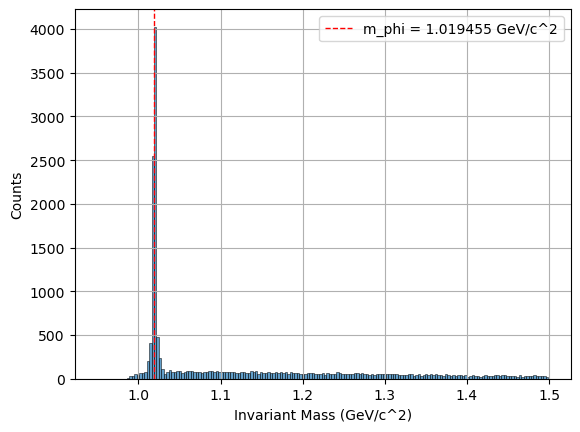

In [31]:
# mass of the phi meson
m_phi = 1.019455

df_phiKK.M.hist(bins=np.arange(0.95, 1.5, 0.003), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 


Text(0, 0.5, 'Counts')

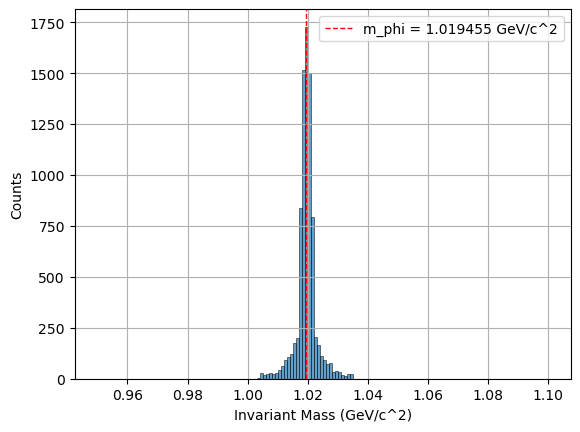

In [32]:
df_phiKK_cut = df_phiKK.loc[(df_phiKK.M > 1.00391) & (df_phiKK.M < 1.035)].reset_index(drop=True)

df_phiKK_cut.M.hist(bins=np.arange(0.95, 1.1, 0.001), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

In [33]:
df_phiKK_cut["PPhi"]=df_phiKK_cut.apply(lambda row: row.PKm+row.PKp, axis=1)
df_phiKK_cut["EPhi"]=df_phiKK_cut.apply(lambda row: row.EKm+row.EKp, axis=1)

Text(0, 0.5, 'counts')

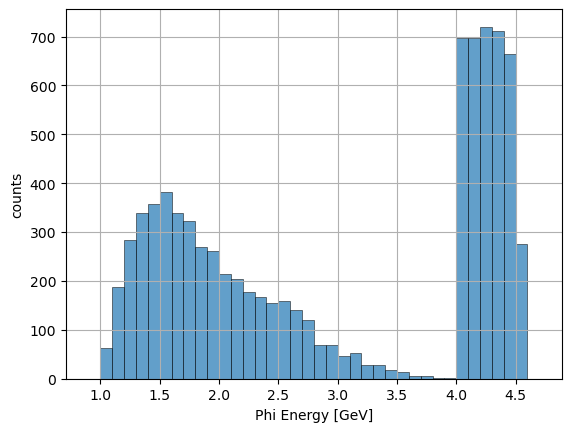

In [34]:
df_phiKK_cut.EPhi.hist(bins =  np.arange(0.9,4.8,0.1), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Phi Energy [GeV]")
plt.ylabel("counts")

In [35]:
# Get all the fluka IDs for the secondary particles
unique_fluka_ids_df = df_phiKK_cut.explode('IDs')['IDs'].unique()

# Get PDG ID, Mass [GeV], and Charge from fluka particle ID
fluka_info = {
    1: (2212, 0.938, 1),      # (PDG ID, Mass [GeV], Charge)
    3: (11, 0.000511, -1),
    4: (-11, 0.000511, 1),
    7: (22, 0, 0),
    8: (2112, 0.9396, 0),
    12: (130, 0.497611 , 0),
    13: (211, 0.13957, 1),
    14: (-211, 0.13957, -1),
    15: (321, 0.493677, 1),
    16: (-321, 0.493677, -1),
    17: (3122, 1.1156, 0),
    19: (310, 0.497648, 0),
    20: (3112, 1.19734, -1),
    21: (3222, 1.189, 1),
    22: (3212, 1.1926, 0),
    23: (111, 0.13498, 0),
    24: (311, 0.4977, 0),
    25: (-311, 0.497648, 0)
}

# Function to convert FLUKA IDs to PDG IDs, masses, and charges
def convert_fluka_ids(ids):
    pdg_ids = []
    masses = []
    charges = []
    for id in ids:
        info = fluka_info.get(id, (None, None, None))  # Get tuple or a default tuple (None, None, None)
        pdg_ids.append(info[0])  # PDG ID
        masses.append(info[1])    # Mass
        charges.append(info[2])   # Charge
    return np.array(pdg_ids), np.array(masses), np.array(charges)

keys_view = fluka_info.keys()  # Get the view object
keys_list = np.array(list(keys_view))

missing_keys = np.setdiff1d(unique_fluka_ids_df, keys_list)

if len(missing_keys) > 0:
    print("Error add the following fluka IDs to the fluka_info dictionary: ", missing_keys)

else:
    # Apply the conversion and create new columns
    df_phiKK_cut[['PDG_IDs', 'Sec_mass', 'Sec_charge']] = df_phiKK_cut['IDs'].apply(convert_fluka_ids).apply(pd.Series)

In [42]:
def write_lhe(df, fluka_dir, header_file="header.txt", include_recoil_e = False, include_other_secondaries = False):


    # Create lhe file and add header
    file = open(fluka_dir+'phi.lhe', "w")


    rscale = 1.740000e+02
    alpha_EM = 7.297353e-03  # Fine-structure constant
    alpha_QCD = 1.078706E-01
    beam_energy = 4.5

    #Write header 
    file.write(f"\n")

    file.write(f"<LesHouchesEvents version=\"3.0\">\n")
    file.write(f"<header>\n")
    file.write(f"</header>\n")

    # Write the body of the LHE file
    file.write(f"<init>\n")
    file.write(f"{11} {623} {beam_energy:.6e} {rscale:.6e} {0} {0} {0} {0} {0} {1}\n")
    file.write("0 0 0 1\n")
    file.write(f"</init>\n")


    # Loop through the DataFrame and write the lines to the file
    for index, row in df.iterrows():

        # Start event block
        file.write(f"<event>\n")


        if include_other_secondaries and include_recoil_e:
            file.write(f"{1+row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        elif include_other_secondaries and (include_recoil_e == False):
            file.write(f"{row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        elif (include_other_secondaries == False) and (include_recoil_e):
            file.write(f"{3:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        else:
            file.write(f"{2:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

        # Include recoil electron if specified
        if include_recoil_e:
            file.write(f"{11:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{-row.ProjkE*row.ProjdirX:>+18.10e}{-row.ProjkE*row.ProjdirY:>+18.10e}{beam_energy-row.ProjkE*row.ProjdirZ:>+18.10e}{beam_energy-row.ProjkE:>17.10e}{5.11E-4:>17.10e}{0:>11.4e} {1:>.4e}\n")

        # Now include the secondaries
        for PDG_ID, P, x, y, z, m, c in zip(row.PDG_IDs,row.Ps,row.Xs,row.Ys,row.Zs, row.Sec_mass, row.Sec_charge):

            # Inlcude all secondaries if specified
            if include_other_secondaries:
                if m != 0:  #If it's not a Photon E= m/sqrt(1-P^2/(P^2 + m^2))
                    file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                else:       #If it is a Photon E = P 
                    file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{P:>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
            
            # Otherwise only include the charged kaons
            elif (PDG_ID == 321) or (PDG_ID == -321):
                file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")

        # end event block
        file.write(f"</event>\n")

    file.write(f"</LesHouchesEvents>")
    file.close()
    print(f"LHE file written to {fluka_dir}phi.lhe")


In [43]:
write_lhe(df_phiKK_cut, fluka_dir, header_file="header.txt", include_recoil_e = False, include_other_secondaries = False)

LHE file written to /Users/mghrear/Lab/HPS/fluka/4550MeV_userdump_s0/phi.lhe
